# TreeInterpreter 

## Definition and intuition 

TreeInterpreter is a simple idea that allows us to have local interpretability for tree based models (Decision trees, Random Forests, ExtraTrees, XGBoost…)
  
It is based on the principle that feature weights are calculated by following decision paths in trees of an ensemble. Each node of the tree has an output score, and contribution of a feature on the decision path is how much the score changes from parent to child.
Every prediction can be trivially presented as a sum of feature contributions, showing how the features lead to a particular prediction. It takes the following form: `prediction = bias + feature_1_contribution + ... + feature_n_contribution` 

This is superficially similar to linear regression, $f(x) = a + bx$. For linear regression the coefficients $b$ are fixed, with a single constant for every feature that determines the contribution. For the decision tree, the contribution of each feature is not a single predetermined value, but depends on the rest of the feature vector which determines the decision path that traverses the tree and thus the guards/contributions that are passed along the way.


For multiple trees, as the prediction is the mean over many predictions, we can say that the contribution of a feature in making a decision is the mean of contributions of the features.

More detailed material can be found at the author blog post [Interpreting random forests](http://blog.datadive.net/interpreting-random-forests/)

### Characteristics 
TreeInterpreter is :
* Model-specific: This method is specific to tree based models 
* Local: we explain the decision for a single sample

## Importations
The library that implements this method is called treeinterpreter ([see on GitHub](https://github.com/andosa/treeinterpreter))

In [1]:
import sklearn as sk

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

# import datasets
from mlinutils.datasets import Bikes, Loans

# specific importations to Treeinterpeter
from treeinterpreter import treeinterpreter as ti
import mlinutils.treeinterpreter_plots as tiplot

import mlinutils.sanity as san

In [2]:
#  make plot outputs appear and be stored within the notebook
%matplotlib inline

## The datasets we're using 

### Data description
The full description of the Datasets that are used in this entire collection of notebooks is available separately 
* Bike sharing: Daily counts of bike rentals from bike sharing along with weather and seasonal information. <a href="bike_sharing_dataset.ipynb">See bike sharing dataset exploration</a>.
* Lending club: information on users and wether or not they default on their payments from a peer to peer lending online service <a href="lending_club_dataset">see lending club dataset exploration</a>  

### Data importation 

In [3]:
# Importing bike sharing and lending club data set
bikes = Bikes()
bk_X_train, bk_X_test, bk_y_train, bk_y_test = bikes.load()

### Data preview
Take a peak into the data we'll be using!

In [4]:
bikes.preview()

This dataset contains 17379 instances with 14 attributes


,season,year,month,hour,holiday,week_day,working_day,weather_situation,temperature,felt_temperature,humidity,wind_speed,count,days_since_2011
2484,summer,0.0,April,6am-10am,0.0,Monday,1.0,Medium,21.32,25.00,55.0,7.0015,109.0,107.0
16025,winter,1.0,November,6am-10am,0.0,Monday,1.0,Good,13.12,15.15,49.0,19.0012,142.0,674.0
4835,fall,0.0,July,6am-10am,0.0,Monday,1.0,Good,32.80,40.15,66.0,0.0000,135.0,205.0
5559,fall,0.0,August,11am-4pm,0.0,Wednesday,1.0,Good,31.16,34.09,48.0,27.9993,236.0,235.0
11711,summer,1.0,May,9pm-5am,0.0,Tuesday,1.0,Medium,21.32,25.00,68.0,22.0028,5.0,493.0


## Application

### Plan
In order to see treeinterpreter in action we will use it for Random Forests models both on regression and classification task
* <a href=#reg>Regression with Bike Sharing</a>
    * <a href=#regm> Model creation and sanity checks</a>
    * <a href=#rege> Explanation </a>
* <a href=#clf>Classification with Lending Club</a>
    * <a href=#clfm> Model creation and sanity checks </a>
    * <a href=#clfe> Explanation </a>
* <a href=#conc>Conclusion</a>

### Regression with Bike Sharing <a name=reg>

#### Model creation and sanity checks <a name=regm>

In [5]:
# Model creation 
bike_rf = RandomForestRegressor(n_estimators=100, max_depth=8, max_features="sqrt", random_state=22) 
bike_rf = bike_rf.fit(bk_X_train, bk_y_train)

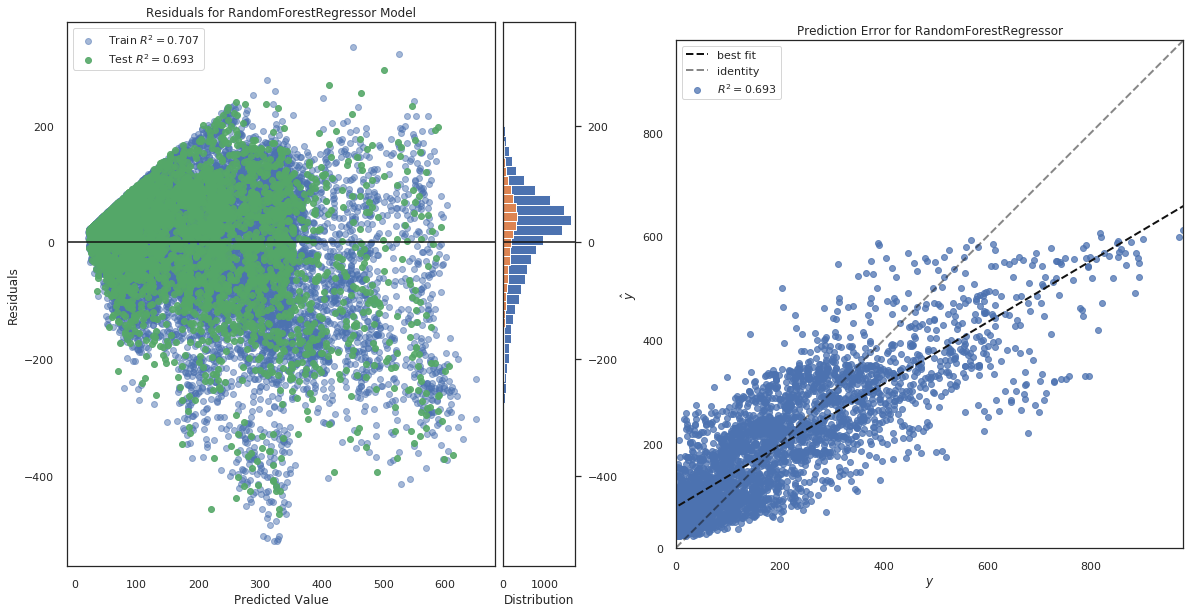

In [6]:
san.regression_sanity_check(bike_rf, bk_X_train, bk_X_test, bk_y_train, bk_y_test)

#### Local Explanation <a name=rege>

In [7]:
sample_bike = bk_X_test.iloc[55]

## recovers the original format just for reading convenience
bikes.data.iloc[[sample_bike.name],:]

,season,year,month,hour,holiday,week_day,working_day,weather_situation,temperature,felt_temperature,humidity,wind_speed,count,days_since_2011
16133,winter,1.0,November,9pm-5am,0.0,Friday,1.0,Good,13.12,16.665,81.0,6.0032,162.0,678.0


Apply TreeInterpreter to the random forest model with the sample to be explained and plot contributions

In [8]:
sb_prediction, sb_bias, sb_contributions = ti.predict(bike_rf, sample_bike.values.reshape(1,-1))

Predicted: 69 bikes
Base value (bias) accounts for: 191 bikes


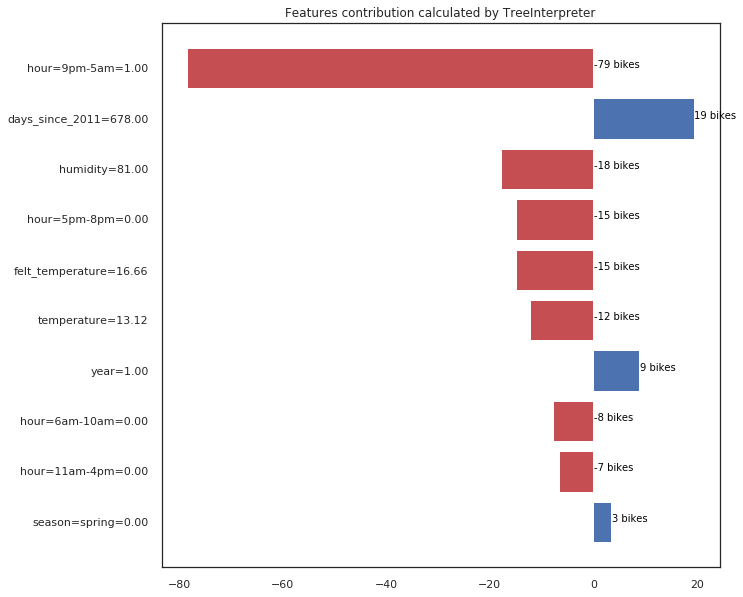

In [9]:
tiplot.regressor_break_down_plot(prediction=sb_prediction,
                                 bias=sb_bias,
                                 contributions=sb_contributions,
                                 sample=sample_bike,
                                 unity="bikes");

> This method of interpretation captures the upwards trend in the bike sharing business but unlike the others it says that temperature and felt temperature contributes negatively! 

### Classification with Lending Club <a name=clf>

In [10]:
# Importing lending club data set
loans = Loans()
ln_X_train, ln_X_test, ln_y_train, ln_y_test = loans.load()

### Data preview
Take a peak into the data we'll be using!

In [11]:
loans.preview()

This dataset contains 98339 instances with 19 attributes


,loan_amnt,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,purpose,dti,delinq_2yrs,inq_last_6mths,open_acc,revol_bal,revol_util,open_acc_6m,inq_fi,mths_since_crl_was_opened,bad_loan_status
24407,21850.0,20.49,584.87,3.0,10.0,MORTGAGE,85000.0,Verified,debt_consolidation,25.89,0.0,1.0,5.0,56999.0,85.2,1.0,1.0,216.020863,0
51753,7800.0,15.31,271.58,5.0,8.0,MORTGAGE,50000.0,Not Verified,debt_consolidation,15.19,0.0,0.0,9.0,7644.0,78.0,1.0,1.0,213.031068,0
58226,14400.0,20.49,385.45,3.0,10.0,OWN,38000.0,Source Verified,debt_consolidation,18.35,0.0,0.0,7.0,13181.0,79.4,1.0,1.0,151.986694,0
43971,2500.0,15.27,59.83,5.0,1.0,RENT,30000.0,Source Verified,car,1.00,0.0,5.0,3.0,1687.0,9.4,1.0,1.0,152.019549,1
76228,13225.0,16.99,471.45,4.0,7.0,OWN,65000.0,Verified,debt_consolidation,10.52,0.0,1.0,9.0,5942.0,51.2,1.0,1.0,160.003285,0


#### Model creation and sanity checks <a name=clfm>

In [12]:
# Model creation 
loan_rf = RandomForestClassifier(n_estimators=100, max_depth=12, max_features="sqrt", random_state=22) 
loan_rf = loan_rf.fit(ln_X_train, ln_y_train)

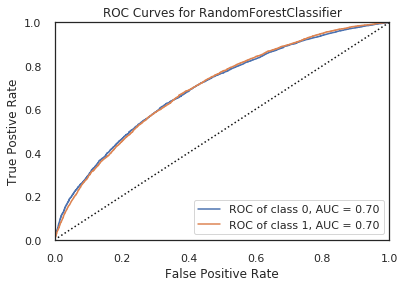

In [13]:
san.classification_sanity_check(loan_rf, ln_X_train, ln_X_test, ln_y_train, ln_y_test)

#### Local Explanation <a name=clfe>

In [14]:
sample_loan = ln_X_test.iloc[42]

## recovers the original format just for reading convenience
loans.data.iloc[[sample_loan.name],:]

,loan_amnt,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,purpose,dti,delinq_2yrs,inq_last_6mths,open_acc,revol_bal,revol_util,open_acc_6m,inq_fi,mths_since_crl_was_opened,bad_loan_status
80149,8000.0,14.64,275.92,5.0,6.0,MORTGAGE,96000.0,Verified,home_improvement,16.89,0.0,4.0,11.0,10899.0,31.6,1.0,1.0,244.966016,0


In [15]:
sl_prediction, sl_bias, sl_contributions = ti.predict(loan_rf, sample_loan.values.reshape(1,-1))

Probability of default: 17.98%
Base value (bias) accounts for: 21.95%


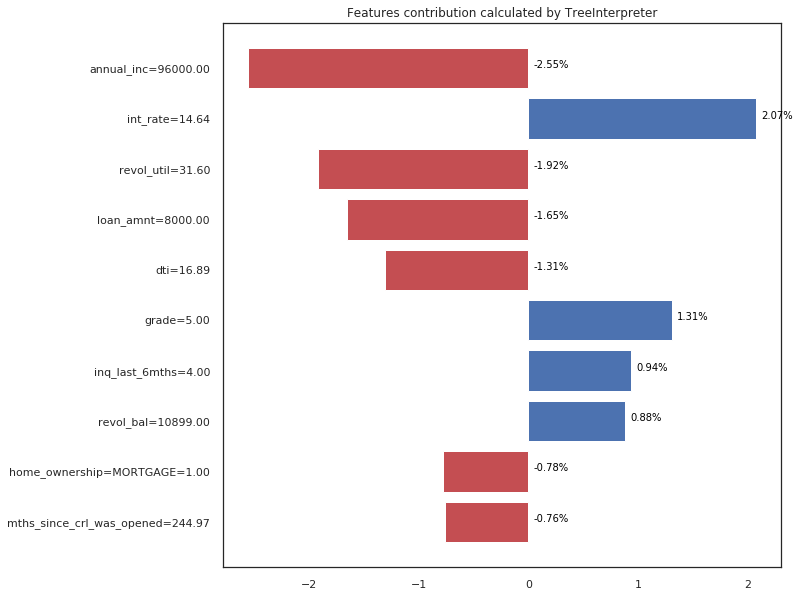

In [16]:
tiplot.classifier_break_down_plot(prediction=sl_prediction,
                                  bias=sl_bias,
                                  contributions=sl_contributions,
                                  sample=sample_loan)

### Conclusion <a name=conc>

TreeInterpreter is a simple idea specific to tree based models. 

<b>Pros</b>
+ Simple and intuitive 
+ Enable tree based model local explanation (i.e. why a particular prediction is made)
+ Enable tree based model debugging


<b>Cons</b>
+ Original Python Package limited to scikit-learn (use ELI5 for XGBoost)
+ Biased towards lower splits in the tree (as trees get deeper, this bias only grows)
